In [ ]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 97.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [102]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from time import time
import spacy
import multiprocessing

In [103]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!wget https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv
!wget https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary.csv

# Preparing Datasets

In [ ]:
summary = pd.read_csv('/content/news_summary.csv', encoding='iso-8859-1', sep=',')
raw = pd.read_csv('/content/news_summary_more.csv', encoding='iso-8859-1',sep =',')

- File data news_summary.csv gồm các cột author, headlines, read_more (đường dẫn đến bài báo), text (đoạn tóm tắt), ctext (bài báo gốc)

- File news_summaryPmore.csv gồm 2 cột headlines và text. Phần nội dang của các ô trong cột text có vẻ ngắn hơn so với file data news_summary.csv.

- Hai file data trên không liên quan đến nhau

In [ ]:
summary.iloc[0]

In [ ]:
raw.iloc[0]

- Đoạn code bên dưới thực hiện gộp data và xử lý chuỗi

In [ ]:
def process_news_data(raw, summary):
    """
    Hàm xử lý hai tập dữ liệu news và trả về DataFrame với cột 'text' và 'summary'.

    Parameters:
    raw (pd.DataFrame): DataFrame chứa cột 'headlines' và 'text'.
    summary (pd.DataFrame): DataFrame chứa cột 'author', 'date', 'read_more', 'text', 'ctext', 'headlines'.

    Returns:
    pd.DataFrame: DataFrame chứa cột 'text' và 'summary'.
    """
    # Tạo bản sao của raw với cột 0 và 1 (headlines, text)
    pre1 = raw.iloc[:, 0:2].copy()

    # Tạo bản sao của summary với cột 0 đến 5 (author, date, read_more, text, ctext, headlines)
    pre2 = summary.iloc[:, 0:6].copy()

    # Kết hợp các cột trong pre2 thành cột 'text'
    pre2['text'] = pre2['author'].str.cat(
        pre2['date'].str.cat(
            pre2['read_more'].str.cat(
                pre2['text'].str.cat(pre2['ctext'], sep=" "),
                sep=" "
            ),
            sep=" "
        ),
        sep=" "
    )

    # Tạo DataFrame pre và nối các cột từ pre1 và pre2
    pre = pd.DataFrame()
    pre['text'] = pd.concat([pre1['text'], pre2['text']], ignore_index=True)
    pre['summary'] = pd.concat([pre1['headlines'], pre2['headlines']], ignore_index=True)

    return pre




#Removes non-alphabetic characters:
def text_strip(column):
    for row in column:

        #ORDER OF REGEX IS VERY VERY IMPORTANT!!!!!!

        row=re.sub("(\\t)", ' ', str(row)).lower() #remove escape charecters
        row=re.sub("(\\r)", ' ', str(row)).lower()
        row=re.sub("(\\n)", ' ', str(row)).lower()

        row=re.sub("(__+)", ' ', str(row)).lower()   #remove _ if it occors more than one time consecutively
        row=re.sub("(--+)", ' ', str(row)).lower()   #remove - if it occors more than one time consecutively
        row=re.sub("(~~+)", ' ', str(row)).lower()   #remove ~ if it occors more than one time consecutively
        row=re.sub("(\+\++)", ' ', str(row)).lower()   #remove + if it occors more than one time consecutively
        row=re.sub("(\.\.+)", ' ', str(row)).lower()   #remove . if it occors more than one time consecutively

        row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower() #remove <>()|&©ø"',;?~*!

        row=re.sub("(mailto:)", ' ', str(row)).lower() #remove mailto:
        row=re.sub(r"(\\x9\d)", ' ', str(row)).lower() #remove \x9* in text
        row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() #replace INC nums to INC_NUM
        row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() #replace CM# and CHG# to CM_NUM


        row=re.sub("(\.\s+)", ' ', str(row)).lower() #remove full stop at end of words(not between)
        row=re.sub("(\-\s+)", ' ', str(row)).lower() #remove - at end of words(not between)
        row=re.sub("(\:\s+)", ' ', str(row)).lower() #remove : at end of words(not between)

        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces

        #Replace any url as such https://abc.xyz.net/browse/sdf-5327 ====> abc.xyz.net
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass #there might be emails with no url in them



        row = re.sub("(\s+)",' ',str(row)).lower() #remove multiple spaces

        #Should always be last
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces
        row = row.strip()

        yield row

In [ ]:
pre  =  process_news_data(raw, summary)

In [ ]:
brief_cleaning1 = text_strip(pre['text'])
brief_cleaning2 = text_strip(pre['summary'])

- Đoạn code phía dưới sử dụng pre-trained model trong thư viện spacy để tiền xử lý dữ liệu. Kết hợp với phương pháp xử lý xng xong (nlp.pipe) để tăng tốc độ xử lý.
- Thông thường, khi gọi spacy model với đoạn text, đoạn text sẽ được tokenize và xử lý theo các components trong mô hình. Khi xử lý lượng lớn dữ liệu, spacy cung cấp phương thức pipe nhận dầu vào là iterator object.

In [ ]:
# Load the model with the full name and disable components for speed
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

t = time()

# Batch the data points into 5000 and run on all cores for faster preprocessing
num_processes = max(1, multiprocessing.cpu_count() // 2)
text = [str(doc) for doc in nlp.pipe(brief_cleaning1, batch_size=1000, n_process=-1)]  # Changed n_threads to n_process

# Print processing time
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
#Taking advantage of spaCy .pipe() method to speed-up the cleaning process:


t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
summary = [str(doc)for doc in nlp.pipe(brief_cleaning2, batch_size=1000, n_process=-1)]

#Takes 7-8 mins
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
import matplotlib.pyplot as plt

def create_word_count_histogram(text, summary):
    """
    Create a histogram comparing word counts of text and summary.

    Parameters:
    text (list): List of text strings
    summary (list): List of summary strings

    Returns:
    None (displays histogram)
    """
    # Create DataFrame with text and summary
    pre = pd.DataFrame({
        'cleaned_text': pd.Series(text),
        'cleaned_summary': pd.Series(summary)
    })

    # Calculate word counts
    text_count = [len(sent.split()) for sent in pre['cleaned_text']]
    summary_count = [len(sent.split()) for sent in pre['cleaned_summary']]

    # Create DataFrame for graphing
    graph_df = pd.DataFrame({
        'text': text_count,
        'summary': summary_count
    })

    # Plot histogram
    graph_df.hist(bins=5)
    plt.show()

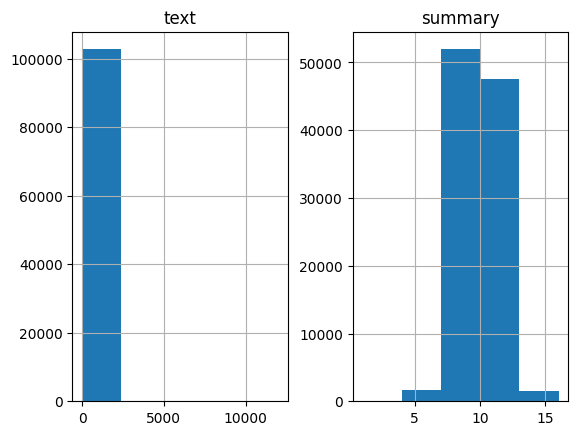

In [ ]:
create_word_count_histogram(text, summary)

- Gộp 2 cột dữ liệu đã được xử lý vào cùng một DataFrame

In [ ]:
pre = pd.DataFrame(columns=['cleaned_text', 'cleaned_summary'])
pre['cleaned_text'] = pd.Series(text)
pre['cleaned_summary'] = pd.Series(summary)

- Lọc ra các hàng dữ liệu dựa vào độ dài. Kết quả đượ lưu vào DataFrame post_pre

In [ ]:
#Model to summarize the text between 0-15 words for Summary and 0-100 words for Text
max_text_len=100
max_summary_len=15
cleaned_text =np.array(pre['cleaned_text'])
cleaned_summary=np.array(pre['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

post_pre=pd.DataFrame({'text':short_text,'summary':short_summary})
post_pre['summary'] = post_pre['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

## Saving & Loading preprocessed data

In [107]:
PATH = '/content/drive/MyDrive/Classroom/Nam3/Semester2/NLP/Lab5'

In [105]:
post_pre.to_csv(PATH + '/processed_news_data.csv', index=False)

In [108]:
post_pre = pd.read_csv(PATH + '/processed_news_data.csv')

## Spliting data for training and validation

In [110]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre['text']),np.array(post_pre['summary']),test_size=0.1,random_state=0,shuffle=True)

## Tokenizer and Padding

- Sử dụng class Tokenizer và hàm pad_sequences của thư viện Keras để phân tách các chuỗi thành các token và chèn các padding token vào chuỗi nhằm đưa về chuỗi có cùng độ dài

### X


In [111]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

In [112]:
thresh=4

cnt=0 # đếm số từ hiếm
tot_cnt=0 # đếm số từ trong vocabulary
freq=0 # Số lần xuất hiện của từ hiếm
tot_freq=0 # Số lần xuất hiện của tất cả các từ

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 57.96869284425888
Total Coverage of rare words: 1.3421538144333909


In [113]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) # Lọc bỏ các từ hiếm
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr)
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 33323


In [ ]:
x_tr

array([[ 1606,   865,  2867, ...,     0,     0,     0],
       [ 2534,  6892, 21846, ...,     0,     0,     0],
       [ 4039,  2475,     4, ...,     0,     0,     0],
       ...,
       [  628,  2886,  1513, ...,     0,     0,     0],
       [ 1540,   785,  2492, ...,     0,     0,     0],
       [ 3610,  4766,    44, ...,     0,     0,     0]], dtype=int32)

### Y

In [114]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

In [115]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 66.26372987737548
Total Coverage of rare words: 4.150151392696801


In [116]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr)
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 11611


In [ ]:
y_tr

array([[   1, 1095,  980, ...,    0,    0,    0],
       [   1,    8,  819, ...,    0,    0,    0],
       [   1, 3030, 2872, ...,    0,    0,    0],
       ...,
       [   1,  116,  814, ...,    0,    0,    0],
       [   1, 2633, 3256, ...,    0,    0,    0],
       [   1, 9503, 8345, ...,    0,    0,    0]], dtype=int32)

In [ ]:
y_tokenizer.index_word[4]

'in'

- Xóa những sample có độ dài tóm tắt nhỏ hơn 2

In [117]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt<=2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

# Summary Model

In [118]:
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Dropout, LayerNormalization, Attention, Concatenate
from tensorflow.keras.models import Model

### Hyperparameters

In [119]:
learning_rate = 0.001
input_dim = x_voc
output_dim = y_voc
encoder_embedding_dim = 256
decoder_embedding_dim = 256
latent_dim = 512
encoder_dropout = 0.3
decoder_dropout = 0.3
batch_size = 64
num_epochs = 200
num_layers = 2


### Encoder

In [120]:
# Input layer
# Input: (batch_size, input_length) -> Output: (batch_size, input_length, output_dim).
encoder_inputs = Input(shape=(max_text_len,))
embedding_layer = Embedding(input_dim=input_dim,
                            output_dim=encoder_embedding_dim,
                            mask_zero=True)
encoder_embedding = embedding_layer(encoder_inputs)
encoder_embedding = LayerNormalization()(encoder_embedding)

# Drop out layer
encoder_embedding = Dropout(encoder_dropout)(encoder_embedding)

# Single LSTM layers
# lstm_layer = LSTM(units=hidden_dim,
#                  return_state=True,
#                  return_sequences=True,
#                  dropout=0.2,
#                  recurrent_dropout=0.2)
# encoder_outputs, state_h, state_c = lstm_layer(encoder_embedding)
# encoder_outputs = LayerNormalization()(encoder_outputs)

# # Multiple LSTM layers
encoder_states = []
for i in range(num_layers):
    lstm_layer = LSTM(units=latent_dim,
                      return_state=True,
                      return_sequences=True,
                      dropout=0.2,
                      recurrent_dropout=0.2)

    if i == 0:
        encoder_outputs, state_h, state_c = lstm_layer(encoder_embedding)
    else:
        # Add residual connection for deeper layers
        lstm_out, state_h, state_c = lstm_layer(encoder_outputs)
        encoder_outputs = encoder_outputs + lstm_out  # Residual connection

    encoder_outputs = LayerNormalization()(encoder_outputs)
    encoder_states.append((state_h, state_c))


## Decoder

In [121]:
# Decoder setup
decoder_inputs = Input(shape=(None,), name="decoder_input")
dec_emb_layer = Embedding(input_dim=output_dim,
                          output_dim=decoder_embedding_dim,
                          mask_zero=True,
                          name="decoder_embedding")
# Get the embeddings of the decoder sequence
dec_emb = dec_emb_layer(decoder_inputs)

# Normalize embeddings to stabilize training
dec_emb_normalize = LayerNormalization()
dec_emb = dec_emb_normalize(dec_emb)

# Apply dropout to prevent overfitting
dec_emb_dropout = Dropout(decoder_dropout, name="decoder_dropout")
dec_emb = dec_emb_dropout(dec_emb)

decoder_outputs = dec_emb
for i in range(num_layers):
    decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True,
                    dropout=encoder_dropout,
                    name=f"decoder_lstm_{i+1}")
    decoder_outputs, state_h2, state_c2 = decoder_lstm(decoder_outputs, initial_state=encoder_states[i])

    if i == 0:
        # Add attention after first decoder layer
        #decoder_outputs = Lambda(lambda x: x)(decoder_outputs)
        #encoder_outputs = Lambda(lambda x: x)(encoder_outputs)
        attention_layer = Attention(name="decoder_attention")
        context_vector = attention_layer([decoder_outputs, encoder_outputs])

        # Concatenate attention context vector with decoder output
        attention_concat = Concatenate(name="attention_concat")
        decoder_outputs = attention_concat([decoder_outputs, context_vector])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_dense = Dense(units=y_voc, activation='softmax', name="decoder_output")
decoder_outputs = decoder_dense(decoder_outputs)


## Seq2Seq Model

In [122]:
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_50      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_19        │ (None, 100, 256)  │  8,530,688 │ input_layer_50[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 256)  │        512 │ embedding_19[0][… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 100, 256)  │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_26        │ (None, 100)       │          0 │ input_layer_50[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_37 (LSTM)      │ [(None, 100,      │  1,574,912 │ dropout_20[0][0], │
│                     │ 512), (None,      │            │ not_equal_26[0][… │
│                     │ 512), (None,      │            │                   │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, None, 256) │  2,972,416 │ decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 512)  │      1,024 │ lstm_37[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 256) │        512 │ decoder_embeddin… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_38 (LSTM)      │ [(None, 100,      │  2,099,200 │ layer_normalizat… │
│                     │ 512), (None,      │            │ not_equal_26[0][… │
│                     │ 512), (None,      │            │                   │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dropout     │ (None, None, 256) │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 100, 512)  │          0 │ layer_normalizat… │
│                     │                   │            │ lstm_38[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm_1      │ [(None, None,     │  1,574,912 │ decoder_dropout[… │
│ (LSTM)              │ 512), (None,      │            │ lstm_37[0][1],    │
│                     │ 512), (None,      │            │ lstm_37[0][2]     │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 512)  │      1,024 │ add_6[0][0]     

 Total params: 25,859,419 (98.65 MB)

 Trainable params: 25,859,419 (98.65 MB)

 Non-trainable params: 0 (0.00 B)

## Optimizer, loss function and callbacks

In [123]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [ ]:
## set up otimizer and loss function ##
model.compile(optimizer=Adam(learning_rate=learning_rate,
                                clipnorm=1.0),
              loss=SparseCategoricalCrossentropy(from_logits=False,
                                                 ignore_class=0))

In [ ]:
best_model_path = '/kaggle/working/best_model.weights.h5'
freq_model_path = '/kaggle/working/frequent_model.weights.h5'

early_stopping = EarlyStopping(monitor='val_loss',
                               mode='min',
                               verbose=1,
                               patience=6)

best_model_checkpoint = ModelCheckpoint(best_model_path,
                                        save_best_only=True,
                                        save_weights_only=True)
freq_model_checkpoint = ModelCheckpoint(freq_model_path,
                                        save_weights_only=True,
                                        save_freq='epoch')

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              mode='min',
                              min_lr=1e-6)

## Training

In [124]:
# Decoder input: starts with 'sostok', excludes last token
decoder_input_data = y_tr[:, :-1]
# Decoder target: excludes 'sostok', includes up to 'eostok'
decoder_target_data = y_tr[:, 1:]

# Prepare validation data similarly
decoder_input_val = y_val[:, :-1]
decoder_target_val = y_val[:, 1:]

In [ ]:
# # Hyperparameter testing ##
# train_samples = 1000
# history = model.fit(x=[x_tr[:train_samples], decoder_input_data[:train_samples]],
#                     y=decoder_target_data[:train_samples],
#                     validation_data=([x_val[:train_samples], decoder_input_val[:train_samples]], decoder_target_val[:train_samples]),
#                     epochs=num_epochs,
#                     batch_size=batch_size,
#                     callbacks=[early_stopping, freq_model_checkpoint, best_model_checkpoint, reduce_lr])


In [ ]:
# history = model.fit(x=[x_tr, decoder_input_data],
#                     y=decoder_target_data,
#                     validation_data=([x_val, decoder_input_val], decoder_target_val),
#                     epochs=num_epochs,
#                     batch_size=batch_size,
#                     callbacks=[early_stopping, best_model_checkpoint, freq_model_checkpoint, reduce_lr])

Epoch 1/200


I0000 00:00:1746082463.127763      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 522s 366ms/step - loss: 7.0698 - val_loss: 6.0766 - learning_rate: 0.0010
Epoch 2/200
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 506s 365ms/step - loss: 5.8099 - val_loss: 5.2800 - learning_rate: 0.0010
Epoch 3/200
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 505s 364ms/step - loss: 5.0481 - val_loss: 4.9011 - learning_rate: 0.0010
Epoch 4/200
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 504s 364ms/step - loss: 4.5791 - val_loss: 4.6565 - learning_rate: 0.0010
Epoch 5/200
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 504s 364ms/step - loss: 4.2273 - val_loss: 4.4876 - learning_rate: 0.0010
Epoch 6/200
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 507s 366ms/step - loss: 3.9451 - val_loss: 4.3435 - learning_rate: 0.0010
Epoch 7/200
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 507s 366ms/step - loss: 3.6978 - val_loss: 4.2186 - learning_rate: 0.0010
Epoch 8/200
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 508s 367ms/step - loss: 3.4653 - val_loss: 4.1147 - learning_rate: 0.0010
Epoch 9/200
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 507s 366ms/step - loss: 3.2470 - 

In [ ]:
# from matplotlib import pyplot
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
# pyplot.legend()
# pyplot.show()

## Load trained model

In [125]:
model.load_weights(PATH + '/best_model.weights.h5')

## Inference

In [126]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

### Encoder

In [127]:
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, encoder_states])

### Decoder

In [128]:
# Decoder input
decoder_inputs = Input(shape=(1,))

encoder_outputs = Input(shape=(max_text_len, latent_dim))
# Input for all encoder states (list of tuples for each layer)
encoder_states_inputs = []
for i in range(num_layers):
    encoder_h = Input(shape=(latent_dim,))
    encoder_c = Input(shape=(latent_dim,))
    encoder_states_inputs.append([encoder_h, encoder_c])


# Get the embeddings of the decoder sequence
dec_emb = dec_emb_layer(decoder_inputs)

# Normalize embeddings to stabilize training
dec_emb = dec_emb_normalize(dec_emb)

# Apply dropout to prevent overfitting
dec_emb = dec_emb_dropout(dec_emb)

decoder_states_outputs = []
decoder_outputs = dec_emb
# First LSTM layer
decoder_lstm1 = model.layers[11]
decoder_outputs, state_h2, state_c2 = decoder_lstm1(dec_emb, initial_state=encoder_states_inputs[0])
context_vector = attention_layer([decoder_outputs, encoder_outputs])
decoder_outputs = attention_concat([decoder_outputs, context_vector])
# Second LSTM layer
decoder_lstm2 = model.layers[15]
decoder_outputs, state_h3, state_c3 = decoder_lstm2(decoder_outputs, initial_state=encoder_states_inputs[1])

decoder_outputs = decoder_dense(decoder_outputs)


In [129]:
decoder_model = Model(
    inputs=[decoder_inputs, encoder_outputs] + [state for states in encoder_states_inputs for state in states],
    outputs=[decoder_outputs] + [state_h2, state_c2] + [state_h3, state_c3]
)

### Predictions

In [130]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    #e_out, e_h, e_c = encoder_model.predict(input_seq)
    e_out, e_states = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    decoder_states = e_states
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h1, c1, h2, c2 = decoder_model.predict([target_seq, e_out] + [state for states in decoder_states for state in states])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        decoder_states = [[h1, c1], [h2, c2]]

    return decoded_sentence

In [131]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [133]:
for i in range(0,10):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:", decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: chhattisgarh governor das tandon has declined the salary hike announced by the centre recently his office said on wednesday tandon will continue to draw ã¢ââ¹1 1 lakh per month instead of the revised salary of ã¢ââ¹3 5 lakh per month the accountant general agreed to this after governor tandon wrote letter expressing his willingness to continue with the old salary 
Original summary: chhattisgarh governor refuses pay hike of ã¢ââ¹2 4 lakh month 
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Predicted summary:  chhattisgarh governor declines salary hike for ã¢ââ¹1 5 lakh m